In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypsa
import cartopy.crs as ccrs

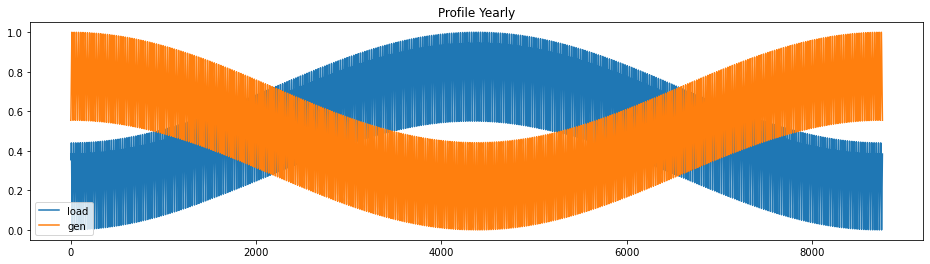

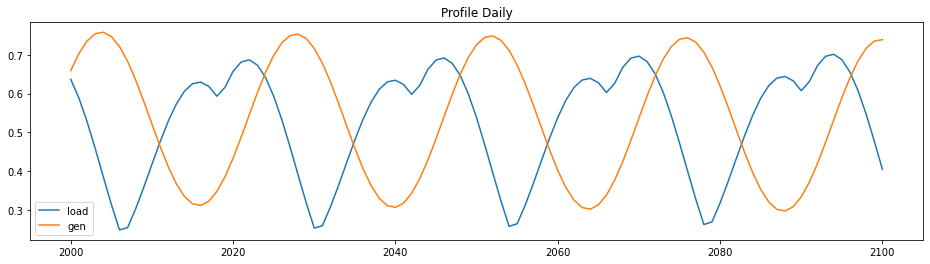

In [5]:
n = 365 * 24

load = np.array((0.3 + 
            np.maximum(0.4 * np.cos(np.linspace(0, 2*365*np.pi, n)), 
            0.5 * np.sin(np.linspace(0, 2*365*np.pi, n)))) +
            (- 0.5*np.cos(np.linspace(0, 2*np.pi, n)) + 0.5))
            
load = load - min(load)
load = load / max(load)
load = pd.Series(load)

generation = np.array((0.3 - 
            0.4 * np.cos(np.linspace(0, 2*365*np.pi, n)) + 
            (0.5*np.cos(np.linspace(0, 2*np.pi, n)) + 0.5)))

generation = generation - min(generation)
generation = generation / max(generation)
generation = pd.Series(generation)
        

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
load.plot(ax=ax, label='load')
generation.plot(ax=ax, label='gen')
ax.legend()
ax.set_title('Profile Yearly')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

load.loc[2000:2100].plot(ax=ax, label='load')
generation.loc[2000:2100].plot(ax=ax, label='gen')
ax.legend()
ax.set_title('Profile Daily')
plt.show()



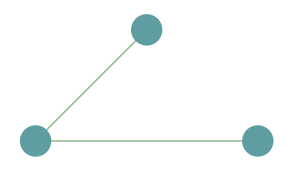

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x35041_copy
  Lower bound: 1988.8659107929122
  Upper bound: 1988.8659107929122
  Number of objectives: 1
  Number of constraints: 61321
  Number of variables: 35041
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 35041
  Number of nonzeros: 87601
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\pypsa\opf.py:1285: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



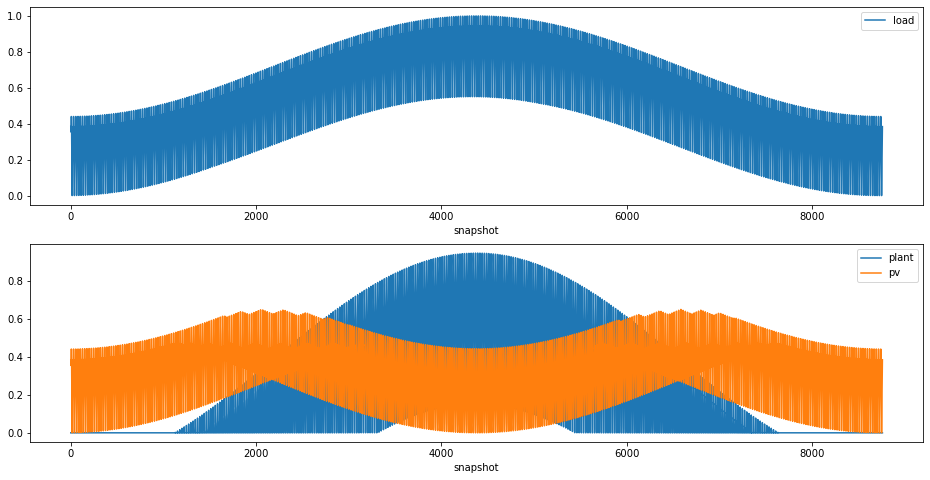

In [22]:
def build_basic_network(snapshots):

    network = pypsa.Network()
    network.snapshots = snapshots

    n = len(snapshots)

    load = np.array((0.3 + 
                np.maximum(0.4 * np.cos(np.linspace(0, 2*365*np.pi, n)), 
                0.5 * np.sin(np.linspace(0, 2*365*np.pi, n)))) +
                (- 0.5*np.cos(np.linspace(0, 2*np.pi, n)) + 0.5))
                
    load = load - min(load)
    load = load / max(load)
    load = pd.Series(load)

    generation = np.array((0.3 - 
                0.4 * np.cos(np.linspace(0, 2*365*np.pi, n)) + 
                (0.5*np.cos(np.linspace(0, 2*np.pi, n)) + 0.5)))

    generation = generation - min(generation)
    generation = generation / max(generation)
    generation = pd.Series(generation)


    network.add('Bus',
                'bus_load',
                carrier='heat')
    network.add('Bus', 
                'bus_plant',
                carrier='heat')
    network.add('Bus', 
                'bus_pv',
                carrier='heat')

    network.add('Load',
                'load',
                bus='bus_load',
                p_set=load,
                carrier='heat')
    network.add('Generator',
                'plant',
                bus='bus_plant',
                p_max_pu=1.,
                p_min_pu=0.,
                marginal_cost=1.,
                p_nom=1,
                carrier='heat')
    network.add('Generator',
                'pv',
                bus='bus_pv',
                carrier='heat',
                p_max_pu=generation,
                marginal_cost=0.,
                p_nom=1.)

    network.add('Link',
                'pv2load',
                bus0='bus_pv',
                bus1='bus_load',
                carrier='heat',
                efficiency=1.,
                p_nom=1. 
                )
    network.add('Link',
                'plant2load',
                bus0='bus_plant',
                bus1='bus_load',
                carrier='heat',
                efficiency=1.,
                p_nom=1.)

    return network

snapshots = pd.Series(range(24*365))
network = build_basic_network(snapshots)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection":ccrs.PlateCarree()})
network.plot(ax=ax)
plt.show()

network.lopf(snapshots, solver_name='gurobi')#, pyomo=False)

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
network.loads_t.p_set.plot(ax=ax[0])
network.generators_t.p.plot(ax=ax[1])
plt.show()

In [56]:
def add_mixed_stes(
                    network,
                    attached_to,
                    stes_charge_ramp_limit_up=0.5,
                    stes_charge_ramp_limit_down=0.5,
                    stes_discharge_ramp_limit_up=0.05,
                    stes_discharge_ramp_limit_down=0.05,
                    tes_ramp_limit_up=0.4,
                    tes_ramp_limit_down=0.4,
                    ):
    '''
    Adds a simple (fully mixed) seasonal 
    thermal storage to the chosen bus.
    The storage is one main storage with large moments
    of inertia in its control and a small storage
    
    Args:
        network(pypsa.Network): to this we will add the store
        attached_to(str): name of load to which the storage is attached
        stes_charge_ramp_limit_up(float): upper bound on change in stes charge
        stes_charge_ramp_limit_down(float): analoguous
        stes_discharge_ramp_limit_up(float): analoguous
        stes_discharge_ramp_limit_down(float): analoguous
        tes_ramp_limit_up(float): max change in discharge of small thermal storage 
        tes_ramp_limit_down(float): analoguous
    '''


    out_bus = network.loads.loc[attached_to]['bus']
    carrier = network.buses.loc[out_bus]['carrier']

    network.add('Bus', 'bus_tes', carrier=carrier)
    network.add('Bus', 'bus_stes', carrier=carrier)

    network.add('Link', 'gen2stes', bus0=out_bus, bus1='bus_stes', 
                    p_nom=1., 
                    efficiency=1., 
                    carrier=carrier,
                    ramp_limit_up=stes_charge_ramp_limit_up,
                    ramp_limit_down=stes_charge_ramp_limit_down,
                    )

    network.add('Link', 'stes2tes', bus0='bus_stes', bus1='bus_tes', 
                    p_nom=1., 
                    efficiency=1., 
                    carrier=carrier,
                    ramp_limit_up=stes_discharge_ramp_limit_up,
                    ramp_limit_down=stes_discharge_ramp_limit_down,
                    )

    network.add('Link', 'test2load', bus0='bus_tes', bus1=out_bus, 
                    p_nom=1., 
                    efficiency=1., 
                    carrier=carrier,
                    ramp_limit_up=tes_ramp_limit_up,
                    ramp_limit_down=tes_ramp_limit_down,
                    )

    # add stes
    network.add('Store', 'stes', bus='bus_stes', carrier='heat', 
                                #e_nom_max=1,
                                #e_nom=len(snapshots),
                                e_nom_extendable=True)
    network.add('Store', 'tes', bus='bus_tes', carrier='heat', 
                                e_nom_max=12,
                                e_nom_extendable=True)

    return network

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x96363_copy
  Lower bound: 1151.1393291589548
  Upper bound: 1151.1393291589548
  Number of objectives: 1
  Number of constraints: 183961
  Number of variables: 96363
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 96363
  Number of nonzeros: 315359
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Terminatio

C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\pypsa\opf.py:1285: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

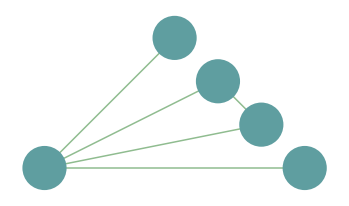

In [57]:
snapshots = pd.Series(range(365*24))

network = build_basic_network(snapshots)
network = add_mixed_stes(network, 'load')

network.plot()

network.lopf(snapshots, solver_name='gurobi')#, pyomo=False)

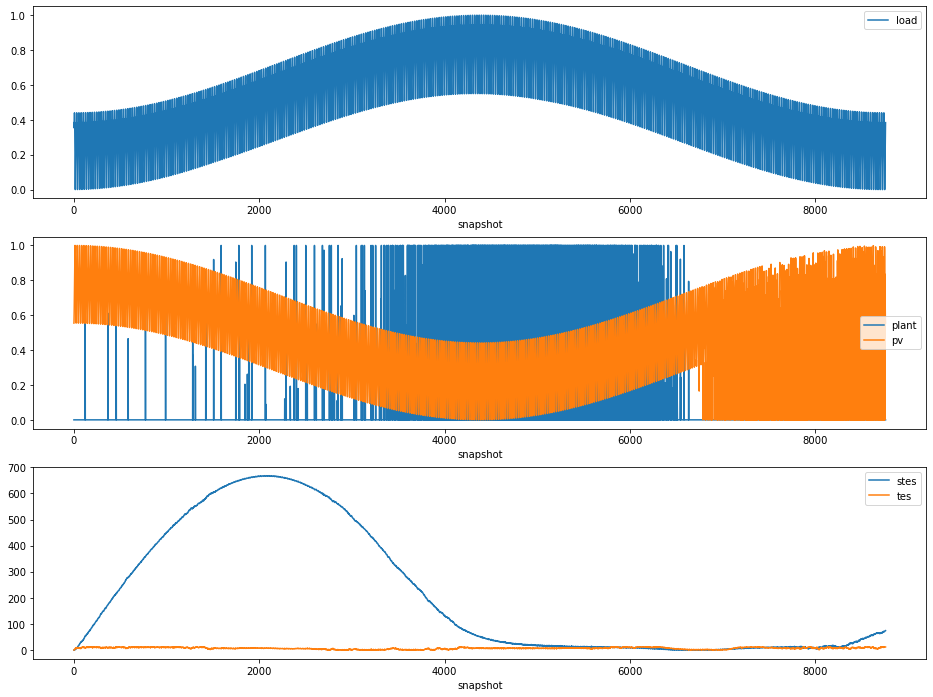

In [55]:
fig, ax = plt.subplots(3, 1, figsize=(16, 12))
network.loads_t.p_set.plot(ax=ax[0])
network.generators_t.p.plot(ax=ax[1])
network.stores_t.e.plot(ax=ax[2])
plt.show()

attribute
v_nom            1.0
type                
x                0.0
y                0.0
carrier         Heat
unit            None
v_mag_pu_set     1.0
v_mag_pu_min     0.0
v_mag_pu_max     inf
control           PQ
sub_network         
Name: bus_load, dtype: object